In [1]:
import os
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy

In [2]:
print("Torch Version",torch.__version__)

Torch Version 0.4.1


In [3]:
main_dir = "data/augmented"
data_dir = os.path.join(main_dir, "Wheat")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(valid_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/augmented\Wheat\train 0
data/augmented\Wheat\train\loged 3360
data/augmented\Wheat\train\Nonloged 6240
******************************
data/augmented\Wheat\valid 0
data/augmented\Wheat\valid\loged 848
data/augmented\Wheat\valid\Nonloged 1552
******************************
data/augmented\Wheat\test 0
data/augmented\Wheat\test\loged 64
data/augmented\Wheat\test\Nonloged 122


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [6]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10, expand=True),
#                                       transforms.CenterCrop(224),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

test_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=dataset_mean,
                                                            std=dataset_std)])

train_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

valid_dataset =  torchvision.datasets.ImageFolder(train_dir,
                                                transform=train_transform)

test_dataset =  torchvision.datasets.ImageFolder(test_dir,
                                                transform=test_transform)

batch_size = 32
dataloaders = {}

dataloaders["train"] = torch.utils.data.DataLoader(train_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["valid"] = torch.utils.data.DataLoader(valid_dataset,
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   num_workers=1)

dataloaders["test"] = torch.utils.data.DataLoader(test_dataset,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  num_workers=1)

dataset_sizes = {"train": len(train_dataset), 
                 "valid":len(valid_dataset),
                 "test":len(test_dataset)}

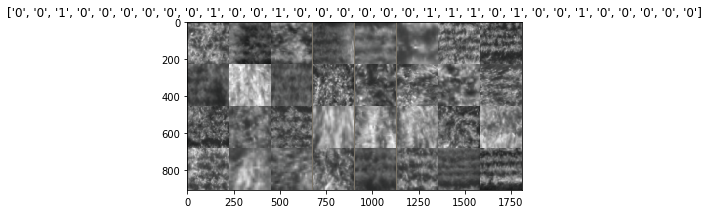

In [7]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[str(x.item()) for x in classes])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print(dataset_sizes)
print(device)

{'train': 9600, 'test': 186, 'valid': 9600}
cuda:0


In [12]:
model = torchvision.models.resnet50(pretrained=True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
#Optimize only the classifier
optimizer = torch.optim.SGD(list(filter(lambda p: p.requires_grad, model.parameters())), lr=0.001, momentum=0.9)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
#         print(".", end="", sep="")
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print(".", end="")
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
if torch.cuda.is_available():
    print("Cuda is available.")
    model = torch.nn.DataParallel(model).cuda();

model = train_model(model, criterion, optimizer, scheduler=None, num_epochs=50)

Cuda is available.
Epoch 0/49
--------------------
train Loss: 0.5448 Acc: 0.8289
valid Loss: 0.3208 Acc: 0.8702

Epoch 1/49
--------------------
train Loss: 0.3169 Acc: 0.8706
valid Loss: 0.2879 Acc: 0.8838

Epoch 2/49
--------------------
train Loss: 0.2868 Acc: 0.8805
valid Loss: 0.2597 Acc: 0.8925

Epoch 3/49
--------------------
train Loss: 0.2828 Acc: 0.8848
valid Loss: 0.2425 Acc: 0.9008

Epoch 4/49
--------------------
train Loss: 0.2619 Acc: 0.8942
valid Loss: 0.2148 Acc: 0.9121

Epoch 5/49
--------------------
train Loss: 0.2445 Acc: 0.8989
valid Loss: 0.2049 Acc: 0.9147

Epoch 6/49
--------------------
train Loss: 0.2231 Acc: 0.9048
valid Loss: 0.2006 Acc: 0.9174

Epoch 7/49
--------------------
train Loss: 0.2046 Acc: 0.9182
valid Loss: 0.1798 Acc: 0.9289

Epoch 8/49
--------------------
train Loss: 0.2004 Acc: 0.9192
valid Loss: 0.1620 Acc: 0.9357

Epoch 9/49
--------------------
train Loss: 0.1812 Acc: 0.9257
valid Loss: 0.1513 Acc: 0.9373

Epoch 10/49
-------------------

In [15]:
torch.save(model.state_dict(), "models/03.wheat_resnet50_augmented.pth")

In [25]:
correct = 0
total = 0
loss = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = criterion(outputs, labels)
        
        y_pred += predicted.to("cpu").detach().numpy().tolist()
        y_true += labels.to("cpu").detach().numpy().tolist()
        
print('Test accuracy: {:.4f}' .format( 100 * correct / total))
print('Test Loss: %.4f'%(test_loss))

Test accuracy: 89.2473
Test Loss: 0.3224


Confusion Matrix
[[111  11]
 [  9  55]]


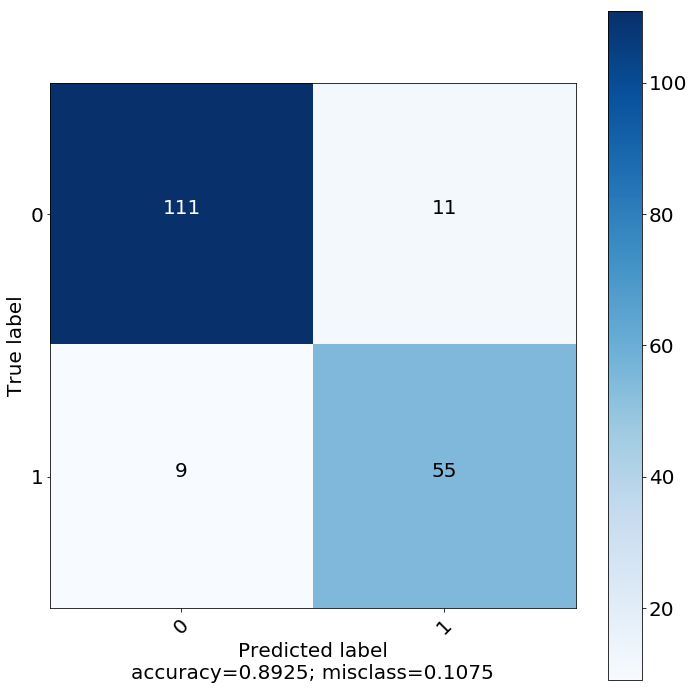

In [26]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))

labels = ['0', '1']

plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [27]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[111  11]
 [  9  55]]


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
classnames=[]
for classname in dataloaders["test"]:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_true, y_pred) 
print(confusion_mtx)
target_names = classnames
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred))

[[111  11]
 [  9  55]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       122
           1       0.83      0.86      0.85        64

   micro avg       0.89      0.89      0.89       186
   macro avg       0.88      0.88      0.88       186
weighted avg       0.89      0.89      0.89       186



In [29]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  89.24731182795699
Sensitivity :  92.5
Specificity :  83.33333333333334


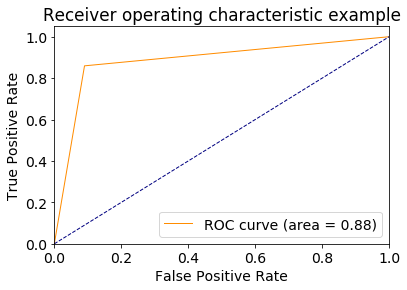

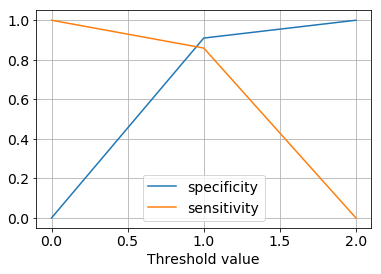

In [30]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [31]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model.named_children():
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True
